# Neural Net from Scratch
An example of a Neural Net from scrath. After the usual imports, we define our neural net and then test it on a basic example. This neural net uses a sigmoid at every stage (even the last one).

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
import random
import time
import sys
from multiprocessing import Process, Queue
%matplotlib inline


In [5]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def tanh(x):
    return np.tanh(x)
#    return 1.72*np.tanh(2.0*x/3)

def identity(x):
    return x

def relu(x):
    rellu = lambda x: x if x>0 else 0
    return np.array([rellu(xi) for xi in x])

def chainDiff(v,f):
    if f == sigmoid:
        return v*(1.0 - v)
    elif f == relu:
        return 1 if v>0 else 0
    elif f == tanh:
        return 1-v**2
#        return 2.0/3*(1.72-v**2/1.72)
    else:
        return 1

In [7]:
'''
Class NeuralNel

arguments: nbrNeurons is a list specifying the number of neurons in each layer, 
           eg: [2,2,3] is a NN with inputs of length 2, one hidden layer with 2 nodes,
               and outputs of length 3.
            activations is a list of functions wich are the activation functions on each layer
            eg: [sigmoid, identity] applies a sigmoid on the first level and nothing on the second
            
further improvements could be to allow [lambda x: x] and other directly defined functions when
creating the NN.

'''

class NeuralNet:
    
    def __init__(self, nbrNeurons, activations = None, weights = None, biases = None):
        
        if activations == None:
            self.activations = [sigmoid for _ in range(nbrNeurons)-1]
        else:
            self.activations = activations
            
        self.nbrNeurons = nbrNeurons
        self.nbrOutputs = nbrNeurons[-1]
        self.nbrLayers = len(nbrNeurons)-1
        
        '''self.neurons = [ [layer,neuron] for layer in range(len(nbrNeurons)) 
                                        for neuron in range(nbrNeurons[layer])]
        self.edges = [[layer, n_arrive, n_depart] for layer in range(self.nbrLayers) 
                                                  for n_arrive in range(self.nbrNeurons[layer+1])
                                                  for n_depart in range(self.nbrNeurons[layer]) ]
        '''
        if weights == None:
        # initial weigths set as random numbers in (0,1)
            self.weights = []
            for i in range(self.nbrLayers):
                self.weights.append(np.random.rand(self.nbrNeurons[i+1], self.nbrNeurons[i]))
        else:
            self.weights = weights
                
        if biases == None:
            self.biases = []
            for i in range(self.nbrLayers):
                self.biases.append(np.random.rand(self.nbrNeurons[i+1]))
        else:
            self.biases = biases
    
    def show_neurons(self):
        print(self.neurons)
        
    def show_weights(self):
        for layer in range(self.nbrLayers):
            print(self.weights[layer])
            print(self.biases[layer])
        
    def predict(self, x):
        if len(x) != self.nbrNeurons[0] :
            print("Wrong size of input !")
        else:
            for i in range(self.nbrLayers):
                x = self.activations[i](np.dot(self.weights[i],x) + self.biases[i])
            return x
    
    def error(self, X, Y):
        err = 0
        for i in range(len(X)):
            pred = self.predict(X[i])
            err += np.linalg.norm(pred-Y[i])
        return err / len(X)
            
            
    def train(self, X, Y, step = 1, epoch = 1):
        for _ in range(epoch):
            order = list(range(len(X)))
            np.random.shuffle(order)
            '''
            with Pool(5) as p:
                A = ([X[order[i],Y[i]] for i in range())
                X = p.starmap(self.train_once, A)
            '''    
            for i in order:
                self.train_once(X[i], Y[i], step = step)
    
    def train_once(self, x, y, step = 1):
        """
        training on 1 entry
        this updates the weights of the model according to the step size and the gradient 
        of the neural net at the error = NN(x)-y
        """
        if len(x) != self.nbrNeurons[0] or len(y)!= self.nbrNeurons[-1]:
            print("Wrong size of x or y !")
        else:
            values = []
            values.append(np.array(x, dtype=float))
            for i in range(self.nbrLayers):
                x = self.activations[i](np.dot(self.weights[i],x) + self.biases[i])
                values.append(x)
            pred = x[-1]
            
            # initialize influence at zero because the first layer of neurons doesn't have
            # influences (this is mainly to keep indices consistent)
            influence = [0]
            
            #selection du neurone 
            for layer in range(1,self.nbrLayers+1):
                infl_layer = []
                
                for neuron in range(self.nbrNeurons[layer]):
                    infl_neuron = []
                    
                    #selection de l'arete
                    for k in range(layer):
                        infl = np.zeros([self.nbrNeurons[k+1],self.nbrNeurons[k]])
                        # i boucle sur les neurones d'arrivee et j sur ceux de depart.
                        for (i,j) in [(i,j) for i in range(self.nbrNeurons[k+1]) 
                                            for j in range(self.nbrNeurons[k])]:
                            
                            # Cas a separer pour avoir une activation differente sur 
                            # certaine couche.
                            if layer-k == 1:
                                if i != neuron:
                                    infl[i,j] = 0
                                else:
                                    #chainDiff(v)
                                    v = values[layer][neuron]
                                    infl[i,j] = chainDiff(v, self.activations[layer-1])*values[k][j]
                            else:
                                # if the edge is too far, we use the chain rule
                                v = values[layer][neuron]
                                w = np.array([influence[layer-1][n][k][i,j] for n in range(self.nbrNeurons[layer-1])])
                                infl[i,j] = chainDiff(v, self.activations[layer-1])*np.dot(self.weights[layer-1][neuron,:], w)
                                
                        infl_neuron.append(infl)

                    #fin de selection d'arete
                    infl_layer.append(infl_neuron)
                influence.append(infl_layer)
            
            influence_B = [0]
            
            #selection du neurone 
            for layer in range(1,self.nbrLayers+1):
                infl_layer = []
                
                for neuron in range(self.nbrNeurons[layer]):
                    infl_neuron = []
                    
                    #selection du B
                    for k in range(layer):
                        infl = np.zeros(self.nbrNeurons[k+1])
                        
                        # i boucle sur les neurones d'arrivee du B.
                        for i in range(self.nbrNeurons[k+1]):
                            
                            if layer-k == 1:
                                if i != neuron:
                                    infl[i] = 0
                                else:
                                    #chainDiff(v)
                                    v = values[layer][neuron]
                                    infl[i] = chainDiff(v, self.activations[layer-1])
                            else:
                                # if the edge is too far, we use the chain rule
                                v = values[layer][neuron]
                                w = np.array([influence_B[layer-1][n][k][i] for n in range(self.nbrNeurons[layer-1])])
                                infl[i] = chainDiff(v, self.activations[layer-1])*np.dot(self.weights[layer-1][neuron,:], w)
                        infl_neuron.append(infl)

                    #fin de selection d'arete
                    infl_layer.append(infl_neuron)
                influence_B.append(infl_layer)


            # use the gradients to calculate the new weights
            delta_weights = []
            delta_biases = []
            for layer in range(self.nbrLayers):
                delta_biases.append(step * influence_B[-1][0][layer]*(pred - y))
                delta_weights.append(step * influence[-1][0][layer]*(pred - y))
                
            for layer in range(self.nbrLayers):
                self.biases[layer] -= delta_biases[layer]
                self.weights[layer] -= delta_weights[layer]
            
            return delta_weights, delta_biases


In [8]:
#creation du neural net
NN = NeuralNet([2,3,1], [sigmoid, tanh])

In [9]:
NN.predict([2,1])

array([ 0.94907315])

In [10]:
#nos données test avec l'erreur du neural net
X = np.array([ [0,0],[0,1],[-3,2],[-3,-3],[2,-3],[5,-4],[2,0],[-5,3],[0,5],[5,5],[5,3],[7,0],[8,2],[10,-3]])
#Y = np.array([ [0]  ,[0]  ,[0]   ,[0]    ,[0]   ,[0]   ,[0]  ,[0]   ,[1]  ,[1]  ,[1]  ,[1]  ,[1]  ,[1]  ])
Y = np.array([ [-1] ,[-1] ,[-1]  ,[-1]   ,[-1]  ,[-1]  ,[-1] ,[-1]   ,[1]  ,[1]  ,[1]  ,[1]  ,[1]  ,[1]  ])
NN.error(X,Y)

1.0910290260701021

In [11]:
#premier round d'entrainement
NN.train(X,Y)
NN.error(X,Y)

0.87635309731880773

In [12]:
# plus de round d'entrainement
NN.train(X,Y, step=0.1, epoch=500)
NN.error(X,Y)

0.025161307460455491

In [13]:
#c'est beaucoup mieux, reposons des donnees test
X_test = np.array([ [-1,-1],[0,-1],[-4,0],[-3,-1],[1,5],[4,4],[9,2],[6,1]])
#Y_test = np.array([ [0]    ,[0]   ,[0]   ,[0]    ,[1]  ,[1]  ,[1]  ,[1]  ])
Y_test = np.array([ [-1]    ,[-1]   ,[-1]   ,[-1]    ,[1]  ,[1]  ,[1]  ,[1]  ])
NN.error(X_test,Y_test)


0.015435875365113302

On voit que l'erreur sur le test set est similaire à l'erreur sur le train set, donc pas trop d'overfit. De plus, l'erreur est bien plus basse qu'avant trainning. Peut-on entrainer le modèle plus longtemps?

In [103]:
# plus de round d'entrainement
NN.train(X,Y, step=0.1,epoch=10000)
NN.error(X,Y)

0.0020915678647154745

In [10]:
# overfit ??
NN.error(X_test,Y_test)

0.0019912093697984547

Wow, toujours pas d'overfit!

126.22336888313293
0.0552125390997
0.0732500537504


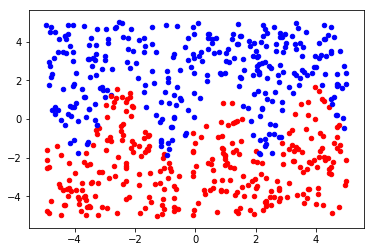

In [13]:
# More complicated test 
# lets define a function and say: above = 1, under = 0
def courbe(x):
    return 2*np.sin(2*x)

'''
X=np.linspace(-5,5,100)
Y=courbe(X)
plt.plot(X,Y)
plt.show()
'''
nbrPoints = 600
    
#creation du train and test set
X_train = 10*np.random.rand(nbrPoints,2)-5
X_test = 10*np.random.rand(nbrPoints,2)-5

f = lambda x: 1 if x[1]>courbe(x[0]) else 0
Y_train = np.array([[f(x)] for x in X_train])
Y_test  = np.array([[f(x)] for x in X_test])

for i in range(nbrPoints):
    color="r"
    if Y_train[i]==1:
        color="b"
    plt.scatter(X_train[i,0],X_train[i,1], s=20,color = color)
    
    
#creation du neural net
NN = NeuralNet([2,10,1], activations = [sigmoid, sigmoid], weights = NNweights, biases = NNbiases)

startTime = time.time()
NN.train(X_train,Y_train, step=0.5,epoch=500)
endTime = time.time()

print(endTime - startTime)

NNbiases = NN.biases
NNweights = NN.weights
print(NN.error(X_train,Y_train))
print(NN.error(X_test,Y_test))

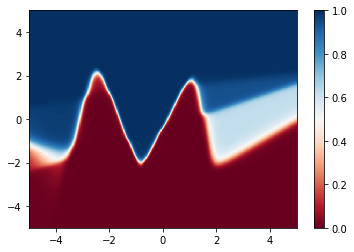

In [14]:
nbrSpots = 500
phi_m = np.linspace(-5, 5, nbrSpots)
phi_p = np.linspace(-5, 5, nbrSpots)
X,Y = np.meshgrid(phi_p, phi_m)
Z=np.zeros([nbrSpots,nbrSpots])
for i in range(nbrSpots):
    for j in range(nbrSpots):
        Z[j,i] = NN.predict([phi_m[i],phi_p[j]])
        
fig, ax = plt.subplots()

p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p)

In [91]:
# More complicated test 
# lets define a function and say: above = 1, under = 0

from multiprocessing import Pool

def courbe(x,y):
    return 2*np.sin(2*x), y

with Pool(5) as p:
    X = p.starmap(courbe, [(8,4),(2,3)])

print(X)
startTime = time.time()
res = []
for i in range(7):
    res.append(courbe(i,2))
print(res[1])
endTime = time.time()

print(endTime - startTime)


[(-0.5758066333301306, 4), (-1.5136049906158564, 3)]
(1.8185948536513634, 2)
0.0010313987731933594


In [52]:
NNbiases

[array([  1.68433228,  28.58524243, -13.74025668,  17.91628909,
         13.03645404,  19.53530872,  -4.97127594, -11.86363178,
        -12.67799085, -10.96090392]), array([ 34.46581975])]

In [51]:
NNbiases.shape()

AttributeError: 'list' object has no attribute 'shape'